# Analyze Queueing and Routing Policies

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Load Dataset

In [118]:
from utils import *
import pandas as pd
from pathlib import Path

# Define root results directory
results_dir = Path('../results')

# Find all files containing "stats" and ending with .csv in all subdirectories
stats_files = sorted(results_dir.glob('**/*stats*.csv'))

# Find all files containing "raw" and ending with .csv in all subdirectories
raw_files = sorted(results_dir.glob('**/*raw*.csv'))

print(f"Found {len(stats_files)} stats CSV files and {len(raw_files)} raw CSV files:")

# Load all stats files into a dictionary of dataframes
stats_dfs = {}
for file_path in stats_files:
    try:
        df = pd.read_csv(file_path)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        # Create key: subfolder_name/filename_stem
        relative_path = file_path.relative_to(results_dir)
        key = str(relative_path.parent / relative_path.stem)
        stats_dfs[key] = df
        print(f"✅ {relative_path} -> shape {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

# Load all raw files into a dictionary of dataframes
raw_dfs = {}
for file_path in raw_files:
    try:
        df = pd.read_csv(file_path)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        # Create key: subfolder_name/filename_stem
        relative_path = file_path.relative_to(results_dir)
        key = str(relative_path.parent / relative_path.stem)
        raw_dfs[key] = df
        print(f"✅ {relative_path} -> shape {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

print(f"\n✅ Loaded {len(stats_dfs)} stats dataframes and {len(raw_dfs)} raw dataframes ✅")

Found 27 stats CSV files and 27 raw CSV files:
✅ cloud/cloud_stats_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_google-gemini-2-5-flash-always_cloud_once_per_sec_2025-12-05T10-00-00.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_google-gemma-3n-e4b-it_always_cloud_once-per-sec_2025-12-05T08-07-39.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_meta-llama-llama-3-2-3b-instruct_always_cloud_once-per-sec_2025-12-05T07-31-00.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_qwen-qwen3-8b_always_cloud_once-per-sec_2025-12-05T0

In [119]:
# Check the keys in raw_dfs
print("Available keys in raw_dfs:")
for key in raw_dfs.keys():
    print(key)

Available keys in raw_dfs:
cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38
cloud/cloud_raw_experiment_google-gemini-2-5-flash-always_cloud_once_per_sec_2025-12-05T10-00-00
cloud/cloud_raw_experiment_google-gemma-3n-e4b-it_always_cloud_once-per-sec_2025-12-05T08-07-39
cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33
cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54
cloud/cloud_raw_experiment_meta-llama-llama-3-2-3b-instruct_always_cloud_once-per-sec_2025-12-05T07-31-00
cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02
cloud/cloud_raw_experiment_qwen-qwen3-8b_always_cloud_once-per-sec_2025-12-05T07-52-16
fabian/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-03T20-58-00
fabian/raw_experiment_Qwen3-4B-ONNX_always_device_once-per-sec_2025-12-06T10-14-33
fabia

## Coming up with a routing policy
We want to find out the optimal Threshold T here for our "smart" scheduling policy. On the hardware we tested, mostly the cloud based inference was faster than on-device. We expect that in the future models will get faster and more people will have more access to higher performance hardware in their devices, thats why we lower the inference time for the on-device models by multiplying it with a `on_device_speedup_factor` and performing a linear shift with `on_device_speedup_shift`.

In [120]:
from utils import *

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-04T08-10-53'].copy()

#df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33'].copy()
#df_device_ex = raw_dfs['philip/raw_experiment_granite-4-0-micro-ONNX-web_always_device_once-per-sec_2025-12-04T09-03-29'].copy()

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02'].copy()
df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_gemma-3-270m-it-ONNX_always_device_once-per-sec_2025-12-04T08-01-13'].copy()



on_device_speedup_factor = 1
on_device_speedup_shift = 00 #linear shift factor in ms

cloud_speedup_factor = 1
cloud_speedup_shift = 0

# Apply speedup factor to device inference times
print(f"on-device: Applying speedup factor {on_device_speedup_factor} and shift -{on_device_speedup_shift}ms...")
print(f"cloud: Applying speedup factor {cloud_speedup_factor} and shift -{cloud_speedup_shift}ms...")

# clip(lower=1.0) to prevent negative inference times!
df_device_ex['inference_time_ms'] = (df_device_ex['inference_time_ms'] * on_device_speedup_factor - on_device_speedup_shift).clip(lower=1.0)
df_cloud_ex['inference_time_ms'] = (df_cloud_ex['inference_time_ms'] * cloud_speedup_factor - cloud_speedup_shift).clip(lower=1.0)

# WARNING: We cannot simply recalculate total_latency_ms here.
# The old 'queueing_time_ms' is invalid because a faster device would have had a much smaller queue.
# We must rely on the M/G/1 simulation to estimate the new total latency.

# Recalculate total latency to maintain consistency (Total = Queue + Inference). ... (Don't do this if you want accurate total stats)
# df_device_ex['total_latency_ms'] = df_device_ex['queueing_time_ms'] + df_device_ex['inference_time_ms']


on-device: Applying speedup factor 1 and shift -0ms...
cloud: Applying speedup factor 1 and shift -0ms...


We now extract basic per-server metrics from the (manipulated) experiment data.

In [121]:
from utils import *

extract_basic_metrics(df_device_ex, "On-Device (Llama)")
extract_basic_metrics(df_cloud_ex, "Cloud (Llama)")

--- Metrics for On-Device (Llama) ---
  Count:                   500
  Duration:                502.43 s
  Arrival Rate (λ):        0.9952 req/s
  Mean Service Demand (S): 0.3874 s
  Mean Response Time (R):  0.4230 s
  Response Time P95:       0.5964 s
  Utilization (ρ = λ*S):   38.55%
------------------------------
--- Metrics for Cloud (Llama) ---
  Count:                   500
  Duration:                604.58 s
  Arrival Rate (λ):        0.8270 req/s
  Mean Service Demand (S): 1.1905 s
  Mean Response Time (R):  51.6434 s
  Response Time P95:       97.2784 s
  Utilization (ρ = λ*S):   98.46%
------------------------------


{'lambda': 0.8270258826020219,
 'mean_service_time': np.float64(1.190498),
 'mean_response_time': np.float64(51.643432000000004),
 'p95_response_time': np.float64(97.2784499999999),
 'utilization': np.float64(0.984572659185942)}

Using the basic per-server metrics we fit a queueing model per server using the measured service time distribution. To find out what queue model we should use. we need to know the distribution of the interarrival times and the distribution of the service times, therefore we plot them.

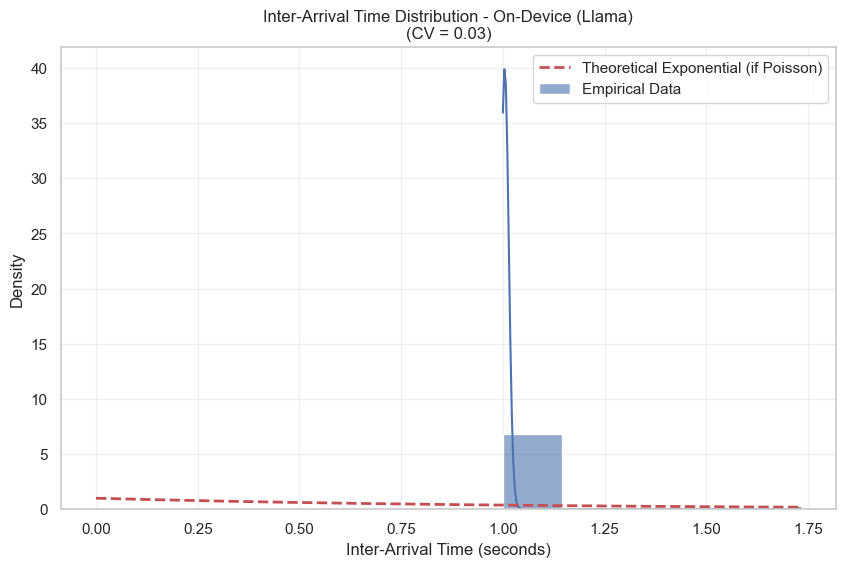

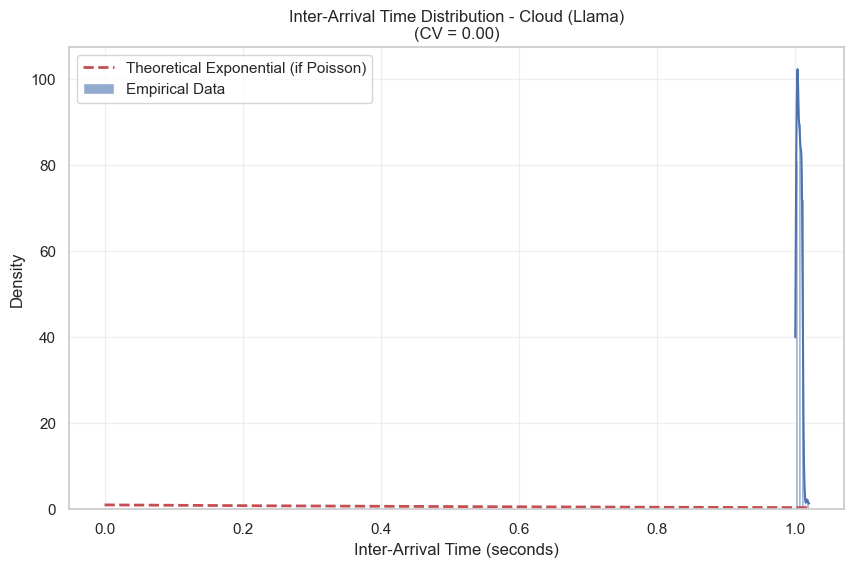

In [122]:
plot_inter_arrival_distribution(df_device_ex, "On-Device (Llama)")
plot_inter_arrival_distribution(df_cloud_ex, "Cloud (Llama)")

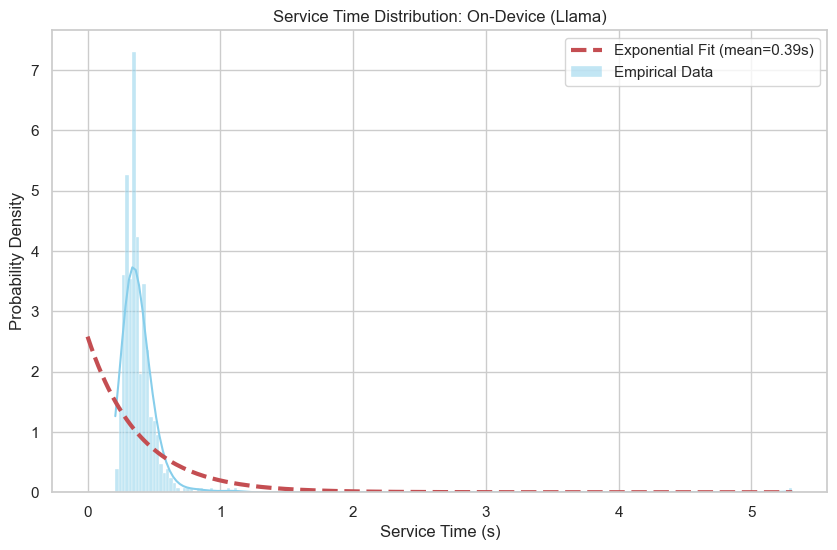

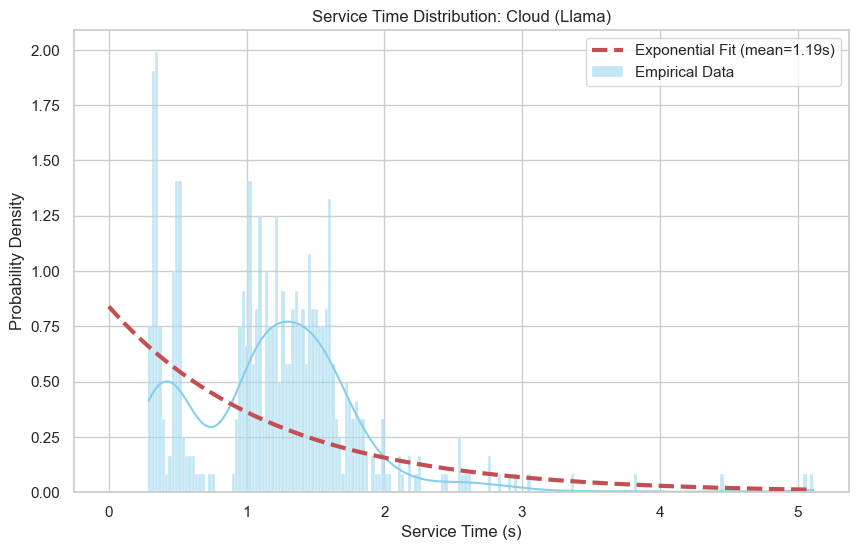

In [123]:
plot_service_time_distribution(df_device_ex, "On-Device (Llama)")
plot_service_time_distribution(df_cloud_ex, "Cloud (Llama)")

We can see that the interarrival times are roughly deterministic. This matches our expectations, as we did the experiments with 1 request per second. The service time distribution plots show that the empirical service times are not clearly exponential, with different shapes and variances for device and cloud. Therefore, for analysis, we model our cloud and on-device systems as **G/G/1** queues (General Arrival, General Service).

Since there is no exact closed-form solution for the mean waiting time in a G/G/1 queue, we use **Kingman's Approximation** (see lecture/literature). The expected waiting time $E[T_Q]$ is approximated as:

$$
E[T_Q] \approx \frac{\rho}{1-\rho} \cdot \frac{c_a^2 + c_s^2}{2} \cdot E[S]
$$

Where:
- $\rho = \lambda E[S]$ is the utilization.
- $E[S]$ is the mean service time.
- $c_a$ is the coefficient of variation of inter-arrival times ($c_a = \sigma_a / \mu_a$).
- $c_s$ is the coefficient of variation of service times ($c_s = \sigma_s / \mu_s$).

This formula generalizes the queueing behavior:
1.  **For our Experiment (G/G/1):** Since arrivals are deterministic, $c_a \approx 0$. The waiting time is driven purely by the service variability ($c_s^2$).
2.  **For M/G/1 (Theoretical):** If we assume random Poisson arrivals, $c_a = 1$. In this case, Kingman's formula simplifies back to the Pollaczek–Khinchine formula.

Using this approximation, we can analytically compute the expected mean response time for both our specific experiment ($c_a=0$) and for a hypothetical real-world scenario with random user arrivals ($c_a=1$).

G/G/1 Analysis | Lambda: 0.9952 | Ca: 0.0 (0=Det, 1=Exp)


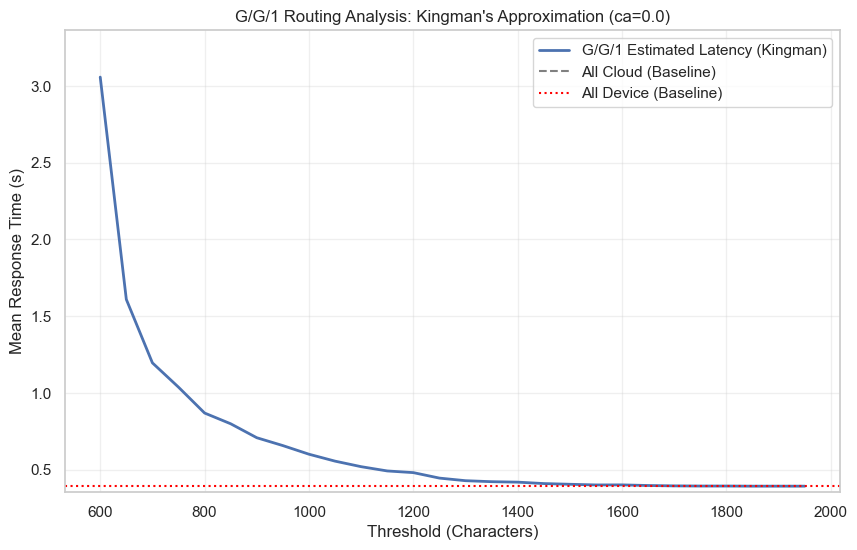

In [124]:
from utils import *

# --- Run Analysis ---
thresholds = range(0, 2000, 50)
# ca=0.0 models your deterministic experiment (D/G/1)
gg1_results = analyze_routing_gg1(df_device_ex, df_cloud_ex, thresholds, ca=0.0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='G/G/1 Estimated Latency (Kingman)', linewidth=2)
# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')
plt.axhline(y=gg1_results.iloc[-1]['avg_latency'], color='red', linestyle=':', label='All Device (Baseline)')

finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max() * 1.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min() * 0.9) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('G/G/1 Routing Analysis: Kingman\'s Approximation (ca=0.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**how to interpret the analyis plot:**
- X-Axis is the Threshold we set for the routing policy. Any prompt with less characters than T is sent to local device, anything longer goes to the cloud. 
- Y-Axis is the Mean Response Time $E[R]$ for the combined system (device and cloud). It's the weighted weighted average time of requests served by device and cloud.
- The optimal Threshold is the minimum of the curve

**To validate the analytical G/G/1 setup (Kingman's approximation), we build a discrete‑event simulation.** We run two variations: one with **Deterministic arrivals** (matching our experiment, $c_a=0$) and one with **Poisson arrivals** (matching theoretical random traffic, $c_a=1$). For each arrival, we apply the routing rule (if size $\le T$ route to device, otherwise to cloud) and simulate the two FCFS queues using empirically sampled service times. For each threshold $T$, we estimate the average response time over many simulated jobs (`num_jobs`) and compare it to the analytical curves. This verifies that the approximation holds for both our specific experimental conditions and general random workloads.

Simulation Lambda: 0.9952 req/s | Ca: 0.0 | Simulating 20000 jobs...
Simulation Lambda: 0.9952 req/s | Ca: 1.0 | Simulating 20000 jobs...


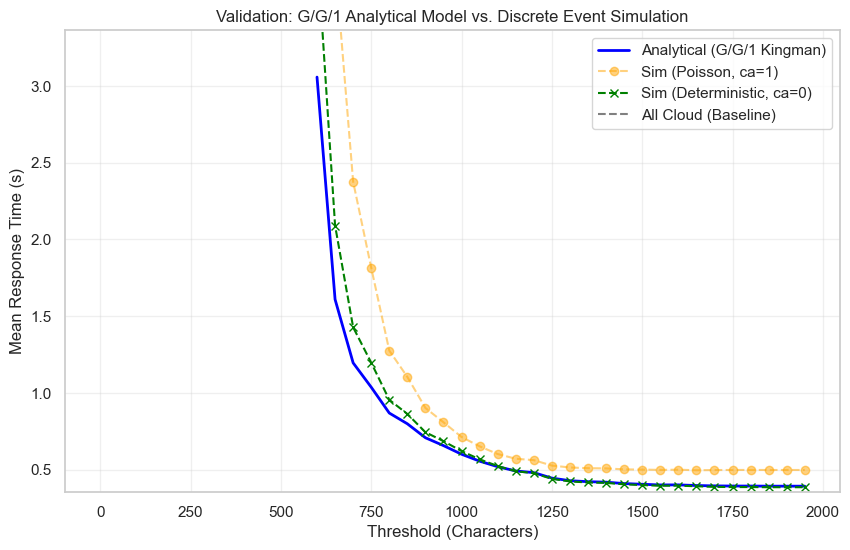

In [125]:
from utils import *

# --- Run Simulation ---
# Use fewer thresholds or jobs if it's too slow
sim_thresholds = range(0, 2000, 50) 

# Calculate Lambda once
lambda_sim = calculate_system_arrival_rate(df_device_ex, df_cloud_ex)

# Run Simulation with Deterministic Arrivals (ca=0.0)
sim_results_det = simulate_routing_validation(df_device_ex, df_cloud_ex, sim_thresholds, lambda_sim, num_jobs=20000, ca=0.0)

# Run Simulation with Poisson Arrivals (ca=1.0)
sim_results_poisson = simulate_routing_validation(df_device_ex, df_cloud_ex, sim_thresholds, lambda_sim, num_jobs=20000, ca=1.0)

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
# Note: Using gg1_results from the previous cell (Analytical Model)
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='Analytical (G/G/1 Kingman)', linewidth=2, color='blue')
plt.plot(sim_results_poisson['threshold'], sim_results_poisson['sim_latency'], 'o--', label='Sim (Poisson, ca=1)', color='orange', alpha=0.5)
plt.plot(sim_results_det['threshold'], sim_results_det['sim_latency'], 'x--', label='Sim (Deterministic, ca=0)', color='green')

# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')

# Dynamic Limits
finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max() * 1.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min() * 0.9) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('Validation: G/G/1 Analytical Model vs. Discrete Event Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The discrete-event simulation shows slightly lower latency than the Kingman approximation. This is expected, as Kingman's formula is an upper-bound approximation that tends to overestimate waiting times for deterministic arrivals at non-saturated utilization levels.


Now we want to look at a fully simulated version. Here we don't sample arrival- and inference time from our experiments, but we generate them artificially. Earlier we identified a linear relationship between input size and inference time, we will use this to generate accurate distributions to sample pairs of input sizes and inference times.

--- On-Device (Llama) ---
Slope: 0.000508 s/char
Intercept: -0.051748 s
R-squared: 0.4969


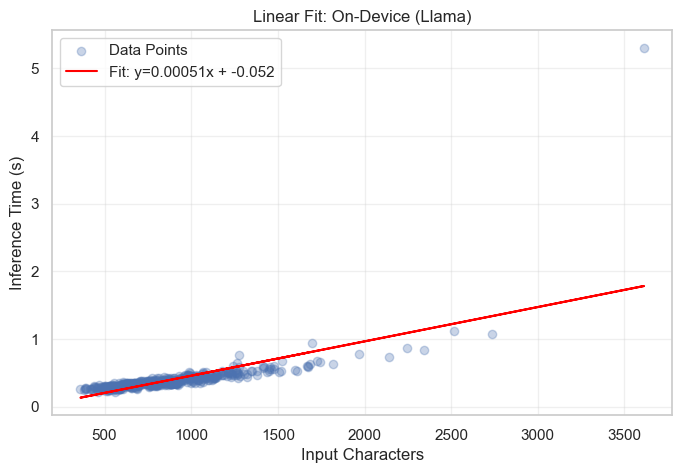

--- Cloud (Llama) ---
Slope: 0.000092 s/char
Intercept: 1.111050 s
R-squared: 0.0024


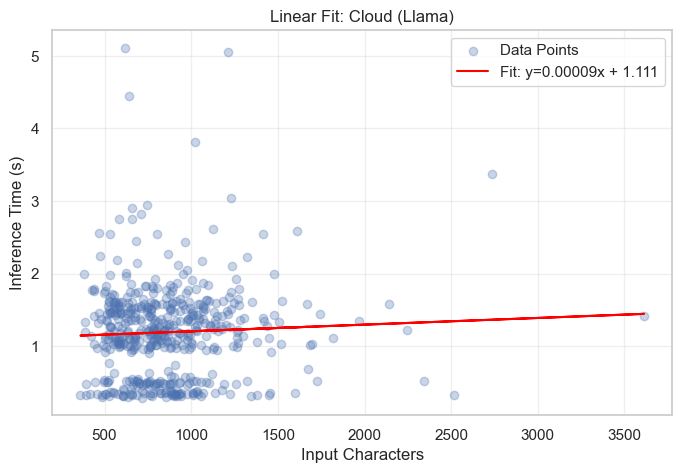


Simulation Params -> Char: (864.7, 340.3)


In [126]:
# Get parameters for Device
slope_dev, int_dev = estimate_linear_relationship(df_device_ex, "On-Device (Llama)")

# Get parameters for Cloud
slope_cloud, int_cloud = estimate_linear_relationship(df_cloud_ex, "Cloud (Llama)")

# Get parameters for Input Character Distribution
char_mean = df_device_ex['number_of_characters'].mean()
char_std = df_device_ex['number_of_characters'].std()

print(f"\nSimulation Params -> Char: ({char_mean:.1f}, {char_std:.1f})")

We can now take the slope and intercept of the cloud and on-device models and use them to generate sample jobs for our simulation. We will generate Gaussian distributed input sizes and calculate the corresponding inference times using the linear models.

0.9951615246670688


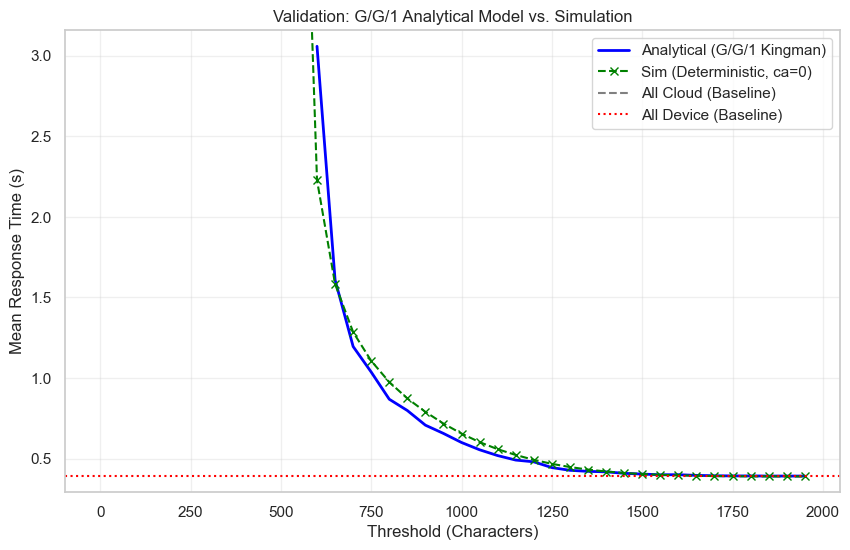

In [127]:
from utils import *

# --- Run Simulation ---
# Use fewer thresholds or jobs if it's too slow
sim_thresholds = range(0, 2000, 50) 

# Calculate Lambda once
lambda_sim = calculate_system_arrival_rate(df_device_ex, df_cloud_ex)
print(lambda_sim)

# Run Simulation with Deterministic Arrivals (ca=0.0)
sim_results_det = simulate_routing_synthetic(sim_thresholds, lambda_sim, num_jobs=100000, ca=0.0, char_params=(char_mean, char_std), dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# Run Simulation with Poisson Arrivals (ca=1.0)
sim_results_poisson = simulate_routing_synthetic(sim_thresholds, lambda_sim, num_jobs=10000, ca=1.0, char_params=(char_mean, char_std), dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
# Note: Using gg1_results from the previous cell (Analytical Model)
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='Analytical (G/G/1 Kingman)', linewidth=2, color='blue')
#plt.plot(sim_results_poisson['threshold'], sim_results_poisson['sim_latency'], 'o--', label='Sim (Poisson, ca=1)', color='orange', alpha=0.5)
plt.plot(sim_results_det['threshold'], sim_results_det['sim_latency'], 'x--', label='Sim (Deterministic, ca=0)', color='green')

# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')
plt.axhline(y=gg1_results.iloc[-1]['avg_latency'], color='red', linestyle=':', label='All Device (Baseline)')

# Dynamic Limits
finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max()+0.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min()-0.1) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('Validation: G/G/1 Analytical Model vs. Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Analyzing Single G/G/1 Queue: On-Device Model ---
Mean Service Time (E[S]): 0.3874 s
Service Rate (μ): 2.58 req/s
Service Time CoV (cs): 0.63


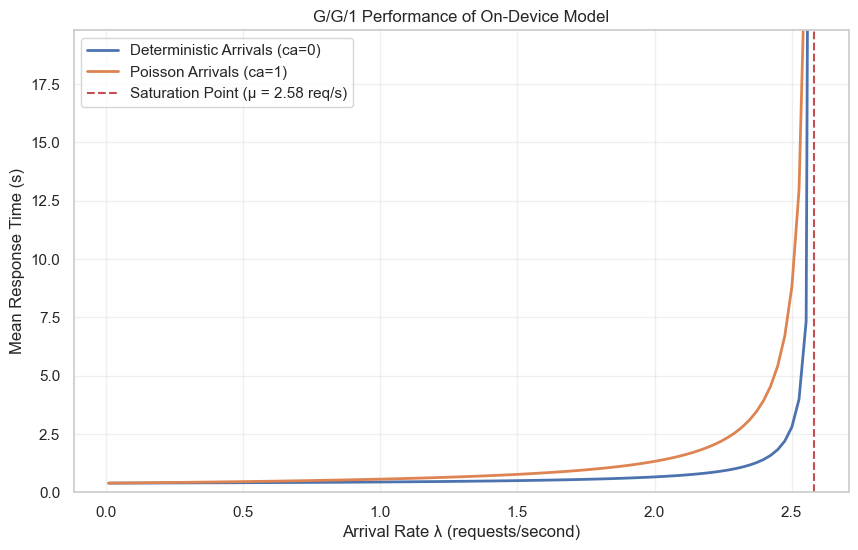

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Select the system to analyze (e.g., the on-device model) ---
# We use the df_device_ex dataframe which may have been modified by the speedup factor.
df_single_system = df_device_ex
system_name = "On-Device Model"

# --- 2. Calculate Service Time statistics from the experimental data ---
# Convert from milliseconds to seconds for calculations
service_times_s = df_single_system['inference_time_ms'] / 1000.0
mean_service_time = service_times_s.mean()
std_dev_service_time = service_times_s.std()

# Service rate (mu) is the inverse of the mean service time
mu = 1.0 / mean_service_time
# Coefficient of variation for service times
cs = std_dev_service_time / mean_service_time

print(f"--- Analyzing Single G/G/1 Queue: {system_name} ---")
print(f"Mean Service Time (E[S]): {mean_service_time:.4f} s")
print(f"Service Rate (μ): {mu:.2f} req/s")
print(f"Service Time CoV (cs): {cs:.2f}")

# --- 3. Define a range of arrival rates (lambda) to test ---
# We test from 0 up to the point of saturation (lambda = mu)
lambda_range = np.linspace(0.01, mu * 0.999, 100)

# --- 4. Calculate Mean Response Time using Kingman's Approximation ---
# We can model both deterministic arrivals (ca=0) and Poisson arrivals (ca=1)
# ca = Coefficient of variation for inter-arrival times
scenarios = {
    "Deterministic Arrivals (ca=0)": 0.0,
    "Poisson Arrivals (ca=1)": 1.0
}
results = {}

for scenario_name, ca in scenarios.items():
    response_times = []
    for lam in lambda_range:
        # Utilization (rho)
        rho = lam * mean_service_time
        
        if rho >= 1:
            # Queue is unstable, latency is infinite
            mean_response_time = float('inf')
        else:
            # Kingman's Approximation for mean waiting time E[Tq]
            mean_wait_time = (rho / (1 - rho)) * ((ca**2 + cs**2) / 2) * mean_service_time
            # Mean Response Time E[R] = E[Tq] + E[S]
            mean_response_time = mean_wait_time + mean_service_time
            
        response_times.append(mean_response_time)
    results[scenario_name] = response_times

# --- 5. Plot the results ---
plt.figure(figsize=(10, 6))
for scenario_name, latencies in results.items():
    plt.plot(lambda_range, latencies, label=scenario_name, linewidth=2)

# Add a vertical line to show the saturation point
plt.axvline(x=mu, color='r', linestyle='--', label=f'Saturation Point (μ = {mu:.2f} req/s)')

plt.xlabel('Arrival Rate λ (requests/second)')
plt.ylabel('Mean Response Time (s)')
plt.title(f'G/G/1 Performance of {system_name}')
plt.legend()
plt.grid(True, alpha=0.3)
# Set a reasonable upper limit for the y-axis to keep the plot readable
plt.ylim(bottom=0, top=np.percentile([r for r in results["Poisson Arrivals (ca=1)"] if r < float('inf')], 98) * 1.5)
plt.show()

--- Analyzing: On-Device Model ---
Mean Service Time (E[S]): 0.3874 s
Service Rate (μ): 2.58 req/s
Service Time CoV (cs): 0.63

--- Analyzing: Cloud Model ---
Mean Service Time (E[S]): 1.1905 s
Service Rate (μ): 0.84 req/s
Service Time CoV (cs): 0.54



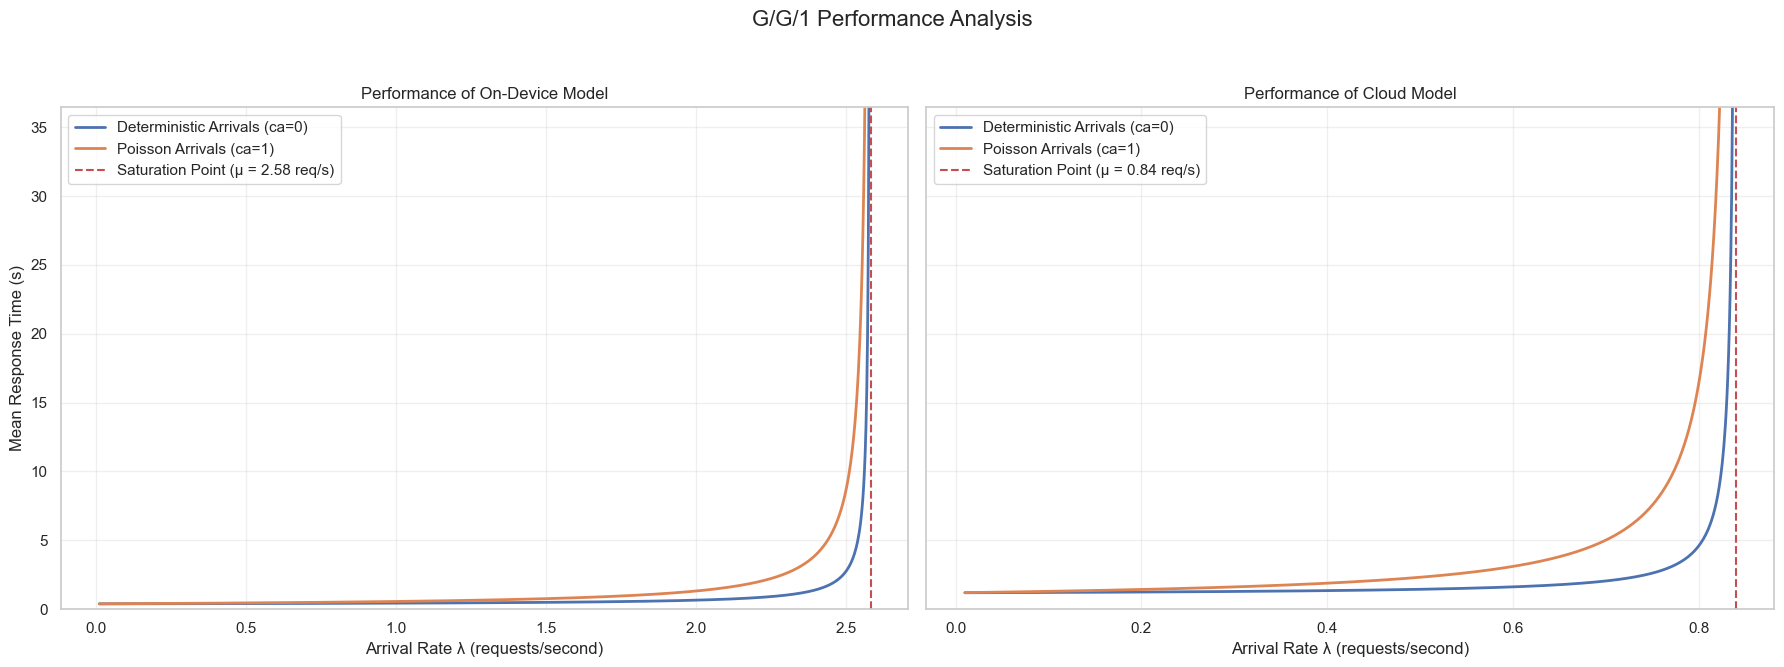

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Create two subplots, one for each system ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('G/G/1 Performance Analysis', fontsize=16)

# --- Define the systems to analyze ---
systems_to_analyze = [
    ("On-Device Model", df_device_ex),
    ("Cloud Model", df_cloud_ex)
]

all_finite_latencies = []

for i, (system_name, df_single_system) in enumerate(systems_to_analyze):
    ax = axes[i] # Select the correct subplot

    # --- 2. Calculate Service Time statistics from the experimental data ---
    service_times_s = df_single_system['inference_time_ms'] / 1000.0
    mean_service_time = service_times_s.mean()
    std_dev_service_time = service_times_s.std()
    mu = 1.0 / mean_service_time
    cs = std_dev_service_time / mean_service_time

    print(f"--- Analyzing: {system_name} ---")
    print(f"Mean Service Time (E[S]): {mean_service_time:.4f} s")
    print(f"Service Rate (μ): {mu:.2f} req/s")
    print(f"Service Time CoV (cs): {cs:.2f}\n")

    # --- 3. Define a range of arrival rates (lambda) to test ---
    lambda_range = np.linspace(0.01, mu * 0.999, 1000)

    # --- 4. Calculate Mean Response Time using Kingman's Approximation ---
    scenarios = {
        "Deterministic Arrivals (ca=0)": 0.0,
        "Poisson Arrivals (ca=1)": 1.0
    }
    results = {}

    for scenario_name, ca in scenarios.items():
        response_times = []
        for lam in lambda_range:
            rho = lam * mean_service_time
            if rho >= 1:
                mean_response_time = float('inf')
            else:
                mean_wait_time = (rho / (1 - rho)) * ((ca**2 + cs**2) / 2) * mean_service_time
                mean_response_time = mean_wait_time + mean_service_time
            response_times.append(mean_response_time)
        results[scenario_name] = response_times
        # Collect finite values for setting y-axis limit later
        all_finite_latencies.extend([r for r in response_times if r < float('inf')])


    # --- 5. Plot the results on the specific subplot ---
    for scenario_name, latencies in results.items():
        ax.plot(lambda_range, latencies, label=scenario_name, linewidth=2)

    ax.axvline(x=mu, color='r', linestyle='--', label=f'Saturation Point (μ = {mu:.2f} req/s)')
    ax.set_xlabel('Arrival Rate λ (requests/second)')
    ax.set_title(f'Performance of {system_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Set a shared y-label
axes[0].set_ylabel('Mean Response Time (s)')

# Set a reasonable upper limit for the y-axis across both plots
if all_finite_latencies:
    upper_limit = np.percentile(all_finite_latencies, 99) * 1.2
    plt.ylim(bottom=0, top=upper_limit)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

We have successfully created a model where we can specify the relationship between input size and inference time for two G/G/1 systems, connected by a threshold-based scheduling policy. This allows us to simulate and optimize the system under various theoretical workloads (deterministic or poisson arrival) and hardware configurations.

--- Running simulations for Deterministic Arrivals (ca=0.0) ---
  -> Simulating λ = 0.5 req/s
--- Running simulations for Poisson Arrivals (ca=1.0) ---
  -> Simulating λ = 0.5 req/s


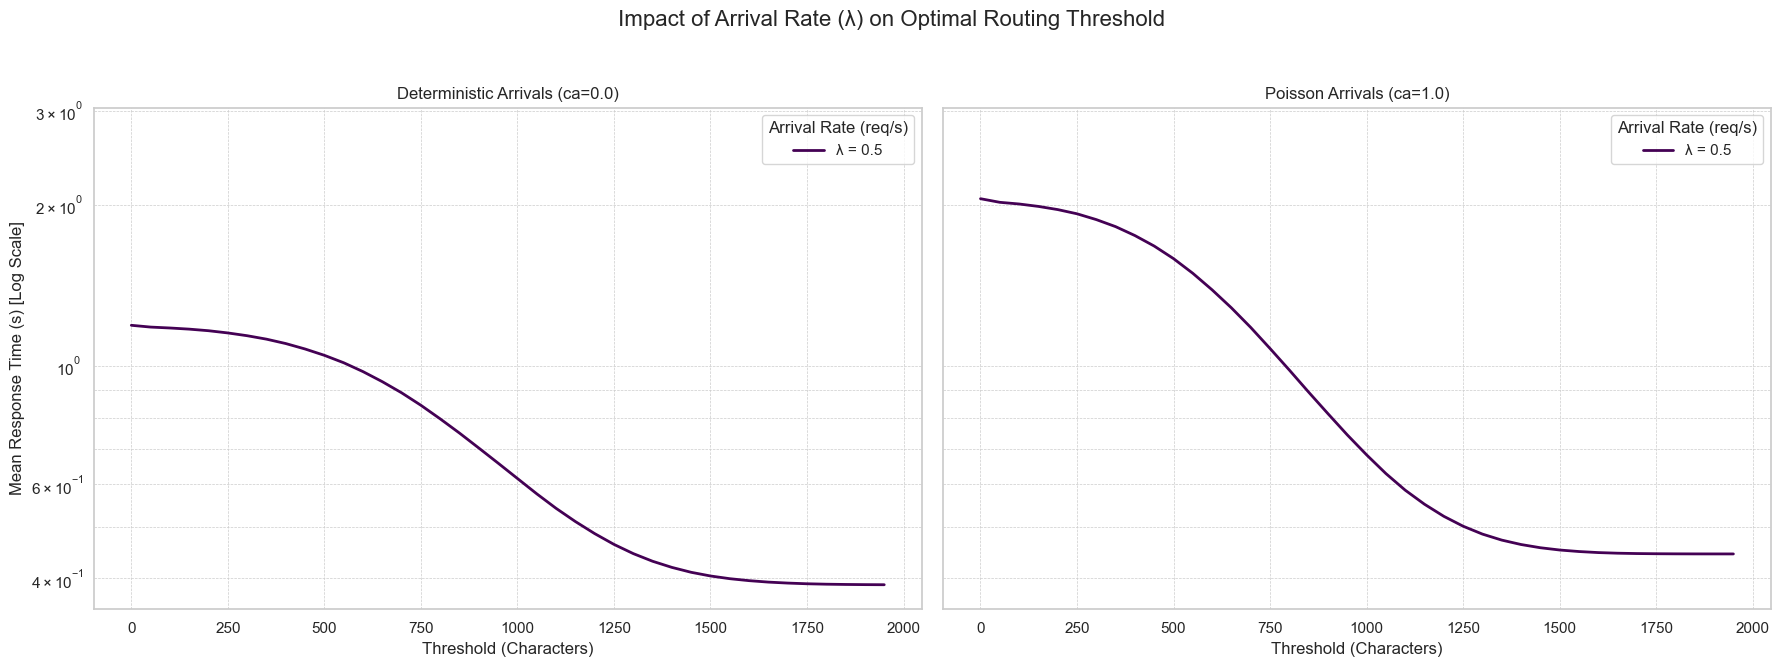

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
# Define a range of arrival rates to test
#test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4.0, 4.5]
test_lambdas = [0.5]
# Define the arrival scenarios to plot
scenarios = {
    "Deterministic Arrivals (ca=0.0)": 0.0,
    "Poisson Arrivals (ca=1.0)": 1.0
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Impact of Arrival Rate (λ) on Optimal Routing Threshold', fontsize=16)

colors = plt.cm.viridis(np.linspace(0, 1, len(test_lambdas)))
all_finite_latencies = []

# --- Loop through scenarios (Deterministic, Poisson) ---
for i, (title, ca_val) in enumerate(scenarios.items()):
    ax = axes[i]
    print(f"--- Running simulations for {title} ---")

    # --- Loop through different arrival rates (lambda) ---
    for j, lam in enumerate(test_lambdas):
        print(f"  -> Simulating λ = {lam:.1f} req/s")
        
        # Run synthetic simulation for the current scenario and lambda
        sim_res = simulate_routing_synthetic(
            thresholds, 
            lam, 
            num_jobs=200000,  # Reduced jobs slightly for faster plotting
            ca=ca_val,
            char_params=(char_mean, char_std), 
            dev_model=(slope_dev, int_dev), 
            cloud_model=(slope_cloud, int_cloud)
        )
        
        # Plot the curve on the correct subplot
        ax.plot(sim_res['threshold'], sim_res['sim_latency'], 
                 label=f'λ = {lam:.1f}', color=colors[j], linewidth=2)
        
        # Collect finite values for auto-scaling the y-axis
        finite_vals = sim_res[sim_res['sim_latency'] != float('inf')]['sim_latency']
        all_finite_latencies.extend(finite_vals.dropna().tolist())

    # --- Configure subplot ---
    ax.set_xlabel('Threshold (Characters)')
    ax.set_title(title)
    ax.legend(title="Arrival Rate (req/s)")
    ax.grid(True, which="both", linestyle='--', linewidth=0.5) # Grid for major and minor ticks
    ax.set_yscale('log') # Set y-axis to log scale

# --- Final plot configuration ---
axes[0].set_ylabel('Mean Response Time (s) [Log Scale]')

# Set reasonable Y-limits across both plots to ignore unstable queues
if all_finite_latencies:
    # Filter out zero or negative values before calculating min for log scale
    positive_latencies = [l for l in all_finite_latencies if l > 0]
    if positive_latencies:
        upper_lim = np.percentile(positive_latencies, 99) * 1.5 # Use percentile for robustness
        lower_lim = min(positive_latencies) * 0.9
        plt.ylim(lower_lim, upper_lim)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Deriving an input size based policy to send to device or cloud

In [131]:
import pandas as pd
import time
import random

# 1. Load the dataset
# Assuming the notebook is in 'analyse/' and the dataset is in 'dataset/' relative to the project root
dataset_path = Path('../dataset/boolq_validation.csv')

if not dataset_path.exists():
    print(f"⚠️ File not found at {dataset_path}. Please check the path.")
else:
    df_requests = pd.read_csv(dataset_path)
    print(f"✅ Loaded {len(df_requests)} requests from {dataset_path.name}")

    # 2. Initialize Estimator
    # Using a 5-second window to react relatively quickly to changes in our simulation loop
    estimator = TrafficRateEstimator(window_size_seconds=5)

    print("\n--- Streaming Requests from Dataset ---")

    # 3. Iterate through requests
    for i, row in df_requests.head(20).iterrows():
        
        # Calculate input size (Question + Passage)
        input_text = str(row['question']) + " " + str(row['passage'])
        input_len = len(input_text)
        
        # Register the arrival of this request
        estimator.register_request()
        
        # Get current load estimate
        current_lambda = estimator.get_current_lambda()
        
        # Make routing decision
        decision, opt_threshold, _ = recommend_routing_decision(
            input_len, 
            current_lambda, 
            (char_mean, char_std), 
            (slope_dev, int_dev), 
            (slope_cloud, int_cloud)
        )
        
        print(f"Req {i+1:02d}: Size={input_len:4d} chars | Est. λ={current_lambda:.2f} | Threshold={opt_threshold} -> Decision: {decision}")
        
        # Simulate variable traffic load with BURSTS
        # Every 20 requests, switch between "High Traffic" (burst) and "Low Traffic" (lull)
        if (i // 20) % 2 == 0:
            # High Traffic Mode: Fast arrivals (0.01s - 0.2s) -> High Lambda
            time.sleep(random.uniform(0.01, 0.1))
        else:
            # Low Traffic Mode: Slow arrivals (0.5s - 1.5s) -> Low Lambda
            time.sleep(random.uniform(0.5, 1.5))

✅ Loaded 3270 requests from boolq_validation.csv

--- Streaming Requests from Dataset ---
Req 01: Size=1417 chars | Est. λ=2.00 | Threshold=1190.0 -> Decision: Cloud
Req 02: Size=1250 chars | Est. λ=4.00 | Threshold=1140.0 -> Decision: Cloud
Req 03: Size= 397 chars | Est. λ=6.00 | Threshold=1090.0 -> Decision: Device
Req 04: Size= 623 chars | Est. λ=7.41 | Threshold=1090.0 -> Decision: Device
Req 05: Size= 418 chars | Est. λ=6.91 | Threshold=1090.0 -> Decision: Device
Req 06: Size= 341 chars | Est. λ=6.61 | Threshold=1090.0 -> Decision: Device
Req 07: Size= 515 chars | Est. λ=6.42 | Threshold=1090.0 -> Decision: Device
Req 08: Size= 664 chars | Est. λ=6.28 | Threshold=1090.0 -> Decision: Device
Req 09: Size= 137 chars | Est. λ=6.18 | Threshold=1090.0 -> Decision: Device
Req 10: Size= 520 chars | Est. λ=6.10 | Threshold=1090.0 -> Decision: Device
Req 11: Size= 820 chars | Est. λ=6.06 | Threshold=1090.0 -> Decision: Device
Req 12: Size= 596 chars | Est. λ=5.99 | Threshold=1090.0 -> Decis

The experiment above shows something that is not fulfilled in our policy: the scheduler does not keep track of how many elements are present in which queue. to avoid overfilling one queue while the other system is idling, we should keep track of how many requests are in the queues of cloud and on device

### including states to keep track of queue lengths
the scheduler is effectively asking: "Including the current backlog, which server will finish this specific job faster?" This is the core principle of the "Join the Shortest Expected Queue" (JSEQ) policy

In [132]:
# join shortest queue size
from utils import *

# 1. Load the dataset
df_requests = pd.read_csv(dataset_path)
print(f"✅ Loaded {len(df_requests)} requests from {dataset_path.name}")

# 2. Initialize Stateful Scheduler with our device/cloud performance models
# Ensure slope_dev, int_dev, etc. have been defined in a previous cell
scheduler = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

print("\n--- Streaming Requests with Stateful JSEQ Scheduler (Advanced Simulation) ---")

# --- Advanced Simulation Setup ---
# We get rid of time.sleep() and manage time manually for a more accurate simulation.
sim_time = 0.0  # This is our simulation's internal clock
total_latency = 0.0
num_requests_processed = 0

# 3. Iterate through requests
for i, row in df_requests.head(500).iterrows():
    
    # Determine next arrival time based on traffic mode
    if (i // 20) % 2 == 0: # Burst mode
        arrival_delay = random.uniform(0.005, 0.15)
    else: # Lull mode
        arrival_delay = random.uniform(0.8, 1.5)
    
    # Advance simulation time to the next arrival
    sim_time += arrival_delay
    
    # Calculate input size
    input_text = str(row['question']) + " " + str(row['passage'])
    input_len = len(input_text)
    
    # Make a state-aware routing decision using the simulation's clock
    decision, start_time, finish_time = scheduler.decide_at_time(input_len, arrival_time=sim_time)
    
    # Calculate and record stats for this request
    queue_time = start_time - sim_time
    service_time = finish_time - start_time
    response_time = finish_time - sim_time # This is queue_time + service_time
    
    total_latency += response_time
    num_requests_processed += 1
    
    # Convert to milliseconds for more readable output
    queue_time_ms = queue_time * 1000
    service_time_ms = service_time * 1000
    
    # Use '<7' to left-align the decision string in a 7-character space
    print(f"Req {i+1:03d} (t={sim_time:6.2f}s): Size={input_len:4d} -> {decision:<7} | Queue: {queue_time_ms:6.1f}ms, Inference: {service_time_ms:6.1f}ms")

print(f"\n--- Simulation Complete ---")
print(f"Average Response Time over {num_requests_processed} requests: {total_latency / num_requests_processed:.4f}s")

✅ Loaded 3270 requests from boolq_validation.csv

--- Streaming Requests with Stateful JSEQ Scheduler (Advanced Simulation) ---
Req 001 (t=  0.14s): Size=1417 -> Device  | Queue:    0.0ms, Inference:  667.9ms
Req 002 (t=  0.17s): Size=1250 -> Device  | Queue:  642.2ms, Inference:  583.1ms
Req 003 (t=  0.26s): Size= 397 -> Cloud   | Queue:    0.0ms, Inference: 1147.6ms
Req 004 (t=  0.38s): Size= 623 -> Device  | Queue: 1013.8ms, Inference:  264.6ms
Req 005 (t=  0.39s): Size= 418 -> Device  | Queue: 1268.4ms, Inference:  160.5ms
Req 006 (t=  0.41s): Size= 341 -> Device  | Queue: 1414.2ms, Inference:  121.4ms
Req 007 (t=  0.52s): Size= 515 -> Device  | Queue: 1417.7ms, Inference:  209.8ms
Req 008 (t=  0.58s): Size= 664 -> Device  | Queue: 1569.4ms, Inference:  285.5ms
Req 009 (t=  0.64s): Size= 137 -> Device  | Queue: 1794.4ms, Inference:   17.8ms
Req 010 (t=  0.73s): Size= 520 -> Cloud   | Queue:  680.7ms, Inference: 1158.9ms
Req 011 (t=  0.82s): Size= 820 -> Device  | Queue: 1632.2ms, I

In [133]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import *

# --- 1. SETUP: Ensure all parameters from previous cells are available ---
# dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud)
# char_params=(char_mean, char_std)
# dataset_path

# --- 2. GENERATE A CONSISTENT REQUEST STREAM ---       SAMPLED FROM DATASET
# Create a fixed list of requests and arrival times to ensure every policy is tested on the exact same workload.
print("--- Generating a consistent once-per-second request stream for simulation ---")
df_requests = pd.read_csv(dataset_path)
num_sim_requests = 500
request_stream = []

# The loop index 'i' will serve as the arrival time in seconds (0, 1, 2, ...)
for i, row in df_requests.head(num_sim_requests).iterrows():
    arrival_time = float(i)
    
    input_text = str(row['question']) + " " + str(row['passage'])
    input_len = len(input_text)
    
    request_stream.append({'id': i, 'arrival_time': arrival_time, 'size': input_len})

# --- 2. GENERATE A CONSISTENT REQUEST STREAM ---   NORMAL DISTRIBUTED
# Create a fixed list of requests with synthetic sizes to ensure every policy is tested on the exact same workload.
print("--- Generating a consistent once-per-second request stream with synthetic input sizes ---")
num_sim_requests = 500
request_stream = []

# The loop index 'i' will serve as the arrival time in seconds (0, 1, 2, ...)
for i in range(num_sim_requests):
    arrival_time = float(i)
    
    # Generate a synthetic input size from a normal distribution
    # Ensure the size is a positive integer
    input_len = int(max(1, np.random.normal(char_mean, char_std)))
    
    request_stream.append({'id': i, 'arrival_time': arrival_time, 'size': input_len})

# --- 3. DEFINE A GENERIC SIMULATION RUNNER ---
def run_policy_simulation(scheduler, requests):
    """Runs a simulation for a given scheduler and request stream."""
    total_latency = 0.0
    for req in requests:
        _, _, finish_time = scheduler.decide_at_time(req['size'], req['arrival_time'])
        response_time = finish_time - req['arrival_time']
        total_latency += response_time
    
    return total_latency / len(requests) if requests else 0.0

# --- 4. PRE-CALCULATE OPTIMAL THRESHOLD FOR THE STATELESS POLICY ---
# Calculate the average lambda of our generated stream to find a reasonable fixed threshold.
avg_inter_arrival_time = request_stream[-1]['arrival_time'] / len(request_stream)
avg_lambda = 1.0 / avg_inter_arrival_time
print(f"\nAverage arrival rate (λ) for the stream: {avg_lambda:.2f} req/s")

# Find the optimal threshold for this average lambda
thresholds = range(0, 2500, 1)
sim_results = simulate_routing_synthetic(
    thresholds, avg_lambda, num_jobs=5000, ca=1.0, 
    char_params=(char_mean, char_std), 
    dev_model=(slope_dev, int_dev), 
    cloud_model=(slope_cloud, int_cloud)
)
# Find the threshold that gives the minimum latency
optimal_T_stateless = sim_results.loc[sim_results['sim_latency'].idxmin()]['threshold']
print(f"Optimal fixed threshold (T) for stateless policy: {optimal_T_stateless} characters")


# --- 5. INITIALIZE ALL SCHEDULERS ---
# We use the StatefulScheduler class for all, but with routing logic overridden for simpler policies.
# This ensures they all share the same underlying queue management mechanics.

# a) Stateful JSEQ Scheduler (no forced policy)
scheduler_jseq = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# b) Always-Cloud Scheduler (forced policy)
scheduler_cloud = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='cloud')

# c) Always-Device Scheduler (forced policy)
scheduler_device = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='device')

# d) Stateless Threshold Scheduler
# For this one, we still need to override the main decision logic, as it's a unique policy.
scheduler_stateless = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))
# Override the main decision method to implement the fixed threshold logic
scheduler_stateless.decide_at_time = lambda size, time: scheduler_stateless.route_to_device(size, time) if size <= optimal_T_stateless else scheduler_stateless.route_to_cloud(size, time)


# --- 6. RUN SIMULATIONS AND GATHER RESULTS ---
print("\n--- Running simulations for all policies ---")
results = {}

results['Always Device'] = run_policy_simulation(scheduler_device, request_stream)
print(f"Finished: Always Device")

results['Always Cloud'] = run_policy_simulation(scheduler_cloud, request_stream)
print(f"Finished: Always Cloud")

results['Stateless Threshold'] = run_policy_simulation(scheduler_stateless, request_stream)
print(f"Finished: Stateless Threshold (T={optimal_T_stateless})")

results['Stateful JSEQ'] = run_policy_simulation(scheduler_jseq, request_stream)
print(f"Finished: Stateful JSEQ")

--- Generating a consistent once-per-second request stream for simulation ---
--- Generating a consistent once-per-second request stream with synthetic input sizes ---

Average arrival rate (λ) for the stream: 1.00 req/s
Optimal fixed threshold (T) for stateless policy: 1423.0 characters

--- Running simulations for all policies ---
Finished: Always Device
Finished: Always Cloud
Finished: Stateless Threshold (T=1423.0)
Finished: Stateful JSEQ



--- Simulation Results ---
Always Device                 : 0.3775s average response time
Always Cloud                  : 48.3589s average response time
Stateless Threshold           : 0.4006s average response time
Stateful JSEQ                 : 0.3775s average response time


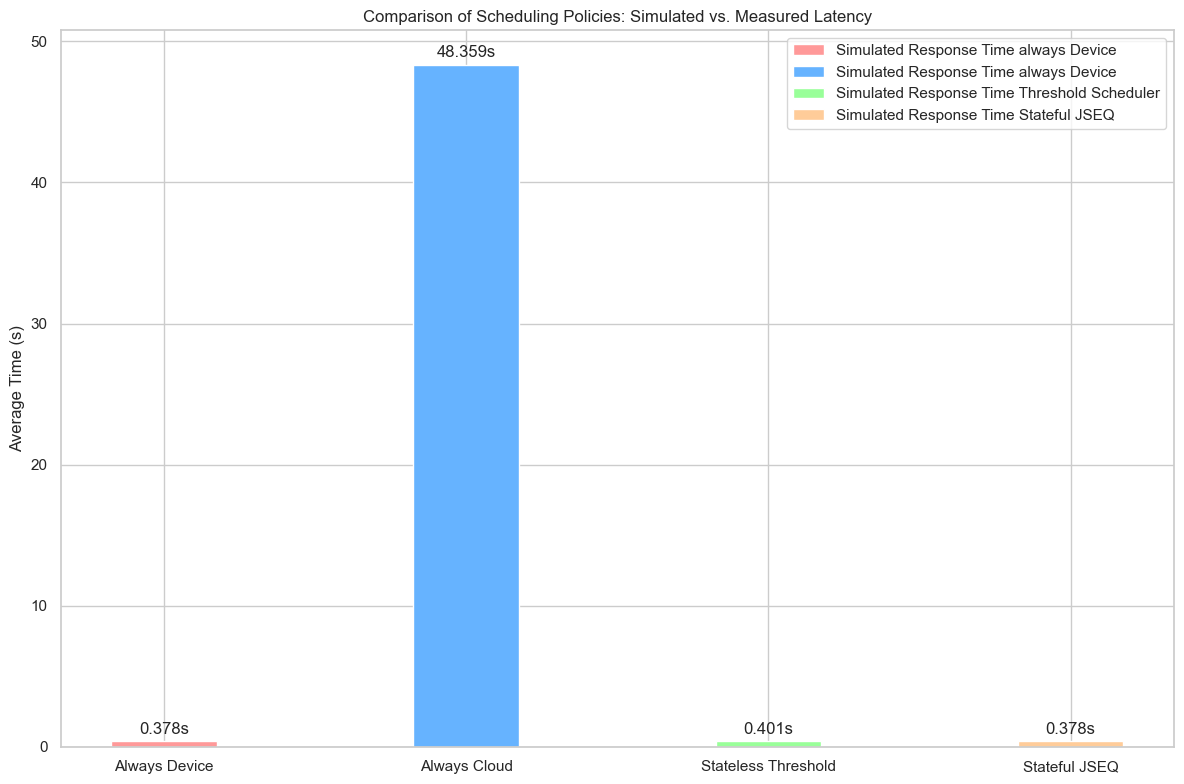

In [134]:
# --- 7. ADD EMPIRICAL INFERENCE TIMES ---

#this version is without the measurements, that's why we don't add empirical inference times here


# --- 8. PLOT AND DISPLAY RESULTS ---
print("\n--- Simulation Results ---")
for policy, latency in results.items():
    print(f"{policy:<30}: {latency:.4f}s average response time")

# Define the categories for the x-axis
categories = ['Always Device', 'Always Cloud', 'Stateless Threshold', 'Stateful JSEQ']
x = np.arange(len(categories))  # the label locations

# Data for the simulated response time bars
sim_latencies = {
    'Always Device': results['Always Device'], 
    'Always Cloud': results['Always Cloud'], 
    'Stateless Threshold': results['Stateless Threshold'], 
    'Stateful JSEQ': results['Stateful JSEQ']
}

bar_width = 0.35  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 8))

# --- Plotting the bars ---
ax.bar(x[0], sim_latencies['Always Device'], bar_width, 
       label='Simulated Response Time always Device', color='#ff9999')
ax.bar(x[1], sim_latencies['Always Cloud'], bar_width, 
       label='Simulated Response Time always Device', color='#66b3ff')
ax.bar(x[2], sim_latencies['Stateless Threshold'], bar_width, 
       label='Simulated Response Time Threshold Scheduler', color='#99ff99')
ax.bar(x[3], sim_latencies['Stateful JSEQ'], bar_width, 
       label='Simulated Response Time Stateful JSEQ', color='#ffcc99')


# Add some text for labels, title and axes ticks
ax.set_ylabel('Average Time (s)')
ax.set_title('Comparison of Scheduling Policies: Simulated vs. Measured Latency')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to attach a text label above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Label all bars plotted
autolabel(ax.patches)

fig.tight_layout()
plt.show()


--- Simulation Results ---
Always Device                 : 0.3775s average response time
Always Cloud                  : 48.3589s average response time
Stateless Threshold           : 0.4006s average response time
Stateful JSEQ                 : 0.3775s average response time
Measured Device Total Latency : 0.4230s average response time
Measured Cloud Total Latency  : 51.6434s average response time


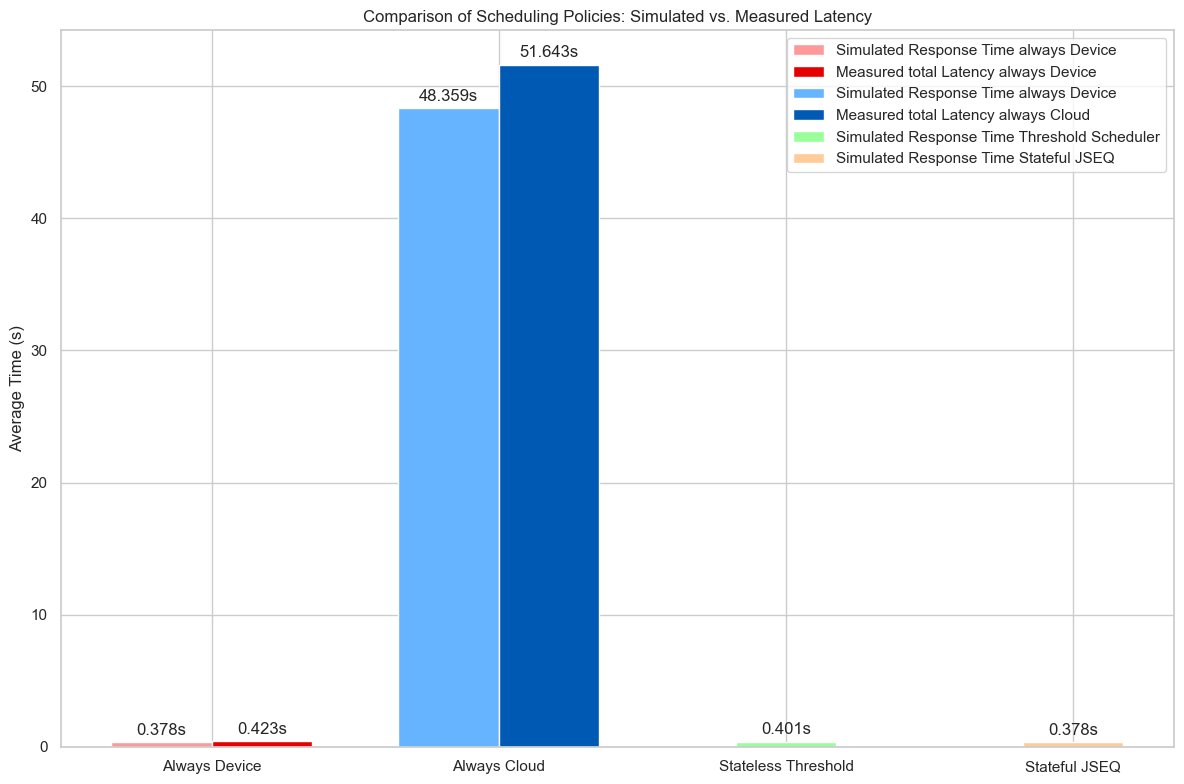

In [135]:
# --- 7. ADD EMPIRICAL INFERENCE TIMES ---
# Calculate the average inference times from the original dataframes
avg_device_inference_ms = df_device_ex['total_latency_ms'].mean()
avg_cloud_inference_ms = df_cloud_ex['total_latency_ms'].mean()

# Add them to the results dictionary, converting from ms to seconds
results['Measured Device Total Latency'] = avg_device_inference_ms / 1000.0
results['Measured Cloud Total Latency'] = avg_cloud_inference_ms / 1000.0


# --- 8. PLOT AND DISPLAY RESULTS ---
print("\n--- Simulation Results ---")
for policy, latency in results.items():
    print(f"{policy:<30}: {latency:.4f}s average response time")

# Define the categories for the x-axis
categories = ['Always Device', 'Always Cloud', 'Stateless Threshold', 'Stateful JSEQ']
x = np.arange(len(categories))  # the label locations

# Data for the simulated response time bars
sim_latencies = {
    'Always Device': results['Always Device'], 
    'Always Cloud': results['Always Cloud'], 
    'Stateless Threshold': results['Stateless Threshold'], 
    'Stateful JSEQ': results['Stateful JSEQ']
}
# Data for the measured total latency bars
measured_latencies = {
    'Always Device': results['Measured Device Total Latency'], 
    'Always Cloud': results['Measured Cloud Total Latency']
}

bar_width = 0.35  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 8))

# --- Plotting the bars ---
ax.bar(x[0] - bar_width/2, sim_latencies['Always Device'], bar_width, 
       label='Simulated Response Time always Device', color='#ff9999')
ax.bar(x[0] + bar_width/2, measured_latencies['Always Device'], bar_width, 
       label='Measured total Latency always Device', color='#e60000')
ax.bar(x[1] - bar_width/2, sim_latencies['Always Cloud'], bar_width, 
       label='Simulated Response Time always Device', color='#66b3ff')
ax.bar(x[1] + bar_width/2, measured_latencies['Always Cloud'], bar_width, 
       label='Measured total Latency always Cloud', color='#0059b3')
ax.bar(x[2], sim_latencies['Stateless Threshold'], bar_width, 
       label='Simulated Response Time Threshold Scheduler', color='#99ff99')
ax.bar(x[3], sim_latencies['Stateful JSEQ'], bar_width, 
       label='Simulated Response Time Stateful JSEQ', color='#ffcc99')


# Add some text for labels, title and axes ticks
ax.set_ylabel('Average Time (s)')
ax.set_title('Comparison of Scheduling Policies: Simulated vs. Measured Latency')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to attach a text label above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Label all bars plotted
autolabel(ax.patches)

fig.tight_layout()
plt.show()


--- Simulation Results ---
Always Device                 : 0.3775s average response time
Always Cloud                  : 48.3589s average response time
Stateless Threshold           : 0.4006s average response time
Stateful JSEQ                 : 0.3775s average response time
Measured Device Total Latency : 0.4230s average response time
Measured Cloud Total Latency  : 51.6434s average response time
Measured JSEQ Total Latency   : 0.3913s average response time


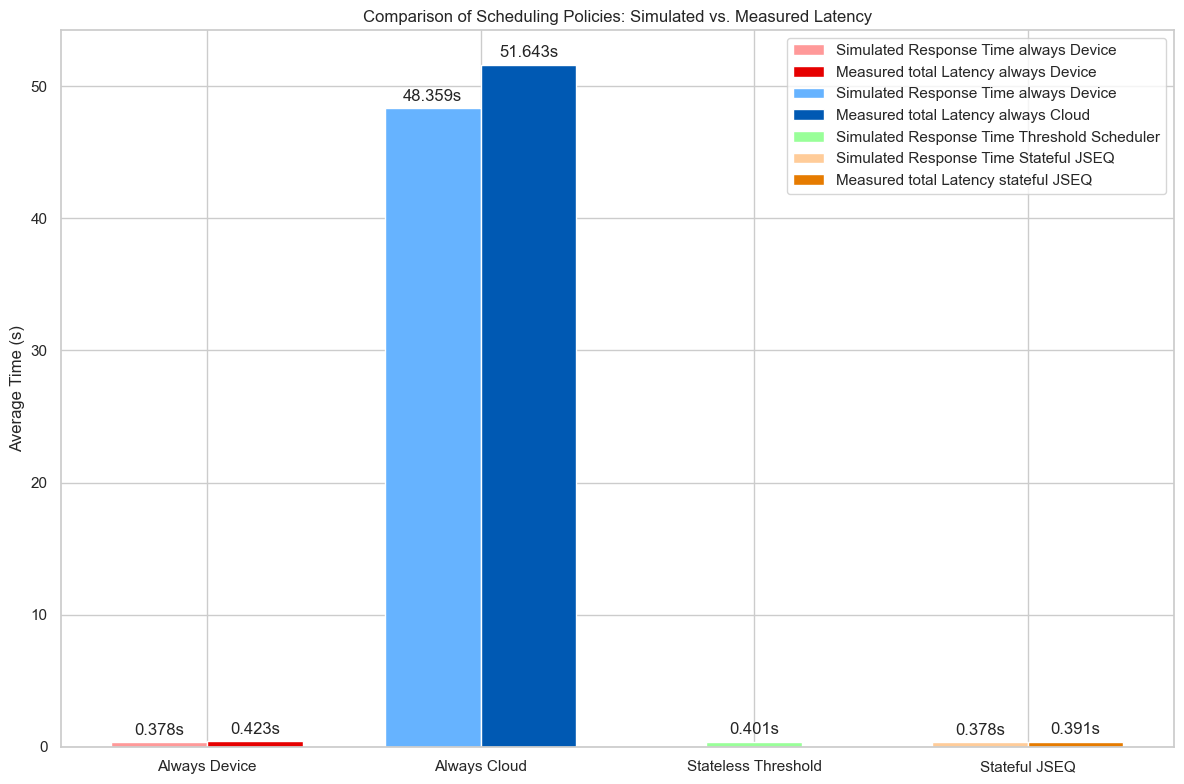

In [136]:
df_jseq_ex = raw_dfs['philip/raw_experiment_gemma-3-270m-it-ONNX_openai-gpt-4o-mini_jseq_once-per-sec_2025-12-08T17-12-38'].copy()

# --- 7. ADD EMPIRICAL INFERENCE TIMES ---
# Calculate the average inference times from the original dataframes
avg_device_inference_ms = df_device_ex['total_latency_ms'].mean()
avg_cloud_inference_ms = df_cloud_ex['total_latency_ms'].mean()
avg_jseq_inference_ms = df_jseq_ex['total_latency_ms'].mean()

# Add them to the results dictionary, converting from ms to seconds
results['Measured Device Total Latency'] = avg_device_inference_ms / 1000.0
results['Measured Cloud Total Latency'] = avg_cloud_inference_ms / 1000.0
results['Measured JSEQ Total Latency'] = avg_jseq_inference_ms / 1000.0


# --- 8. PLOT AND DISPLAY RESULTS ---
print("\n--- Simulation Results ---")
for policy, latency in results.items():
    print(f"{policy:<30}: {latency:.4f}s average response time")

# Define the categories for the x-axis
categories = ['Always Device', 'Always Cloud', 'Stateless Threshold', 'Stateful JSEQ']
x = np.arange(len(categories))  # the label locations

# Data for the simulated response time bars
sim_latencies = {
    'Always Device': results['Always Device'], 
    'Always Cloud': results['Always Cloud'], 
    'Stateless Threshold': results['Stateless Threshold'], 
    'Stateful JSEQ': results['Stateful JSEQ']
}
# Data for the measured total latency bars
measured_latencies = {
    'Always Device': results['Measured Device Total Latency'], 
    'Always Cloud': results['Measured Cloud Total Latency'],
    'Stateful JSEQ': results['Measured JSEQ Total Latency']
}

bar_width = 0.35  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 8))

# --- Plotting the bars ---
ax.bar(x[0] - bar_width/2, sim_latencies['Always Device'], bar_width, 
       label='Simulated Response Time always Device', color='#ff9999')
ax.bar(x[0] + bar_width/2, measured_latencies['Always Device'], bar_width, 
       label='Measured total Latency always Device', color='#e60000')
ax.bar(x[1] - bar_width/2, sim_latencies['Always Cloud'], bar_width, 
       label='Simulated Response Time always Device', color='#66b3ff')
ax.bar(x[1] + bar_width/2, measured_latencies['Always Cloud'], bar_width, 
       label='Measured total Latency always Cloud', color='#0059b3')
ax.bar(x[2], sim_latencies['Stateless Threshold'], bar_width, 
       label='Simulated Response Time Threshold Scheduler', color='#99ff99')
ax.bar(x[3] - bar_width/2, sim_latencies['Stateful JSEQ'], bar_width, 
       label='Simulated Response Time Stateful JSEQ', color='#ffcc99')
ax.bar(x[3] + bar_width/2, measured_latencies['Stateful JSEQ'], bar_width, 
       label='Measured total Latency stateful JSEQ', color="#e67b00")


# Add some text for labels, title and axes ticks
ax.set_ylabel('Average Time (s)')
ax.set_title('Comparison of Scheduling Policies: Simulated vs. Measured Latency')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to attach a text label above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Label all bars plotted
autolabel(ax.patches)

fig.tight_layout()
plt.show()

--- Running simulations for different arrival rates ---

>>> Simulating for λ = 0.20 req/s...
  Optimal stateless T for λ=0.20 is 1423.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4082s
  - Always Cloud (anthropic-claude-haiku-4-5): 1.3790s
  - Stateless Threshold : 0.4305s
  - Stateful JSEQ       : 0.4080s

>>> Simulating for λ = 0.40 req/s...
  Optimal stateless T for λ=0.40 is 1423.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4310s
  - Always Cloud (anthropic-claude-haiku-4-5): 1.7327s
  - Stateless Threshold : 0.4485s
  - Stateful JSEQ       : 0.4294s

>>> Simulating for λ = 0.60 req/s...
  Optimal stateless T for λ=0.60 is 1423.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4588s
  - Always Cloud (anthropic-claude-haiku-4-5): 2.6717s
  - Stateless Threshold : 0.4707s
  - Stateful JSEQ       : 0.4544s

>>> Simulating for λ = 0.80 req/s...
  Optimal stateless T for λ=0.80 is 1423.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4923s
  - Always Cloud (anthr

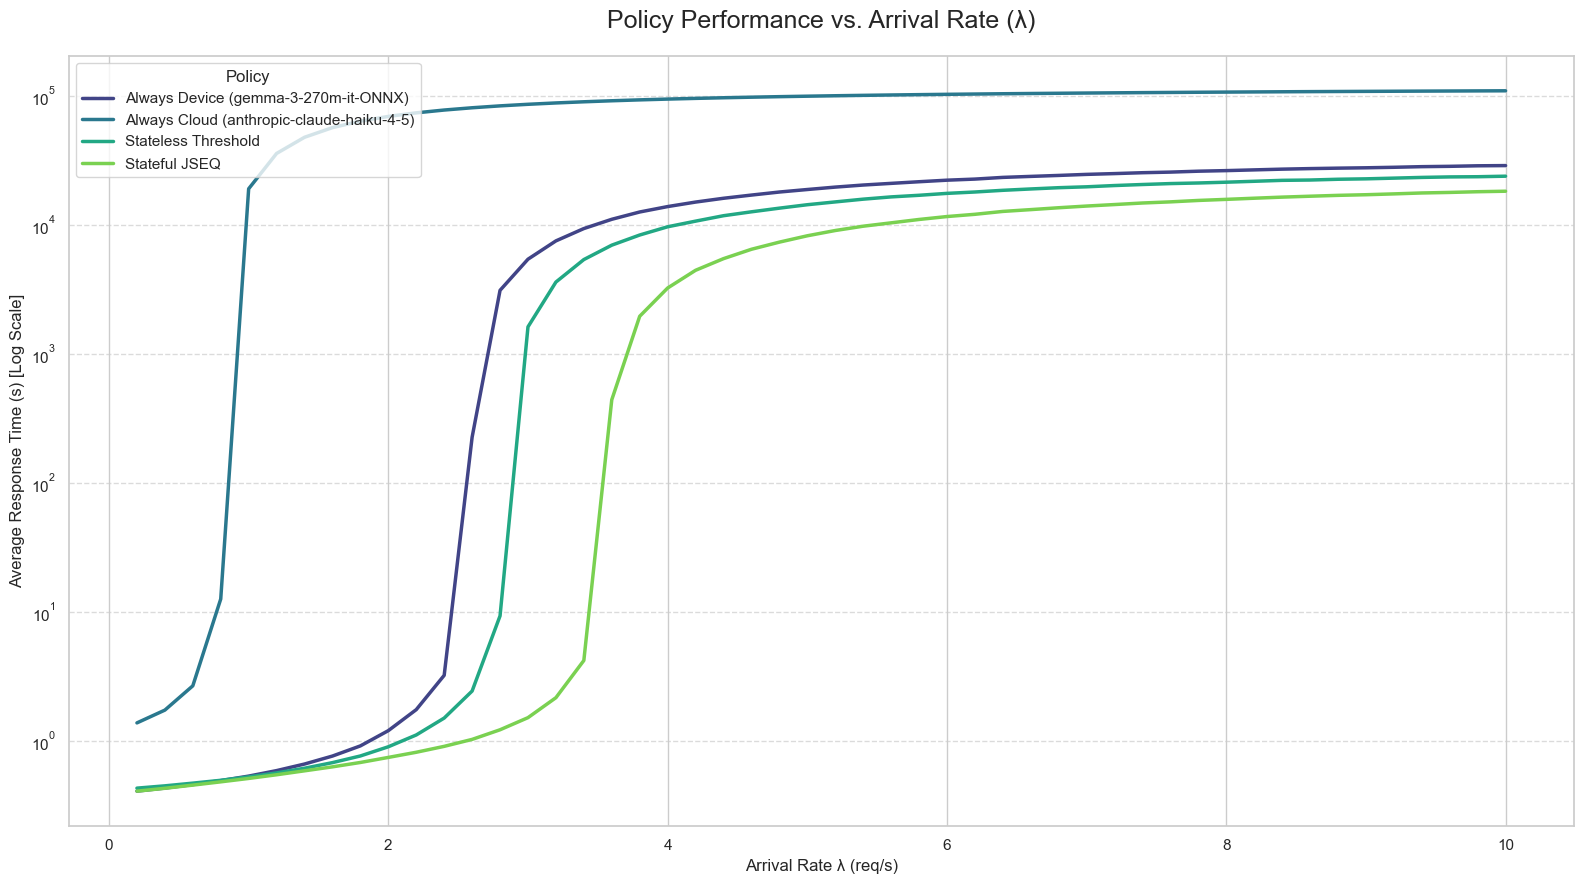

lambda,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,...,8.2,8.4,8.6,8.8,9.0,9.2,9.4,9.6,9.8,10.0
policy,,,,,,,,,,,,,,,,,,,,,
Always Device (gemma-3-270m-it-ONNX),0.408226,0.430987,0.458771,0.492328,0.533591,0.588709,0.661888,0.763138,0.914884,1.201076,...,26594.855479,26943.897587,27211.379814,27427.496338,27604.574654,27854.596576,28166.827445,28337.508347,28605.446280,28711.886227
Always Cloud (anthropic-claude-haiku-4-5),1.379041,1.732681,2.671731,12.577637,18981.959322,35658.373995,47579.506762,56524.898741,63454.809029,69037.577894,...,106861.846161,107163.139300,107438.505921,107694.340124,107933.026144,108176.616422,108422.657796,108634.806155,108857.909679,109044.511895
Stateless Threshold,0.430478,0.448481,0.470658,0.495145,0.526575,0.564955,0.614130,0.678681,0.764445,0.900625,...,21698.568437,22064.766037,22190.799810,22498.171551,22666.377956,22951.780900,23250.013082,23458.112337,23537.832125,23762.850107
Stateful JSEQ,0.407967,0.429383,0.454415,0.481721,0.511869,0.546536,0.586386,0.629425,0.680653,0.744799,...,16040.385689,16356.398513,16622.459143,16879.372001,17071.554976,17327.230885,17615.713991,17785.545096,18012.683449,18171.987032


In [137]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import *

# --- FIX RANDOM SEED FOR REPRODUCIBILITY ---
random.seed(0)
np.random.seed(0)

# --- 1. SETUP ---
# Define the arrival rates (lambda) you want to test
test_lambdas = np.linspace(0.2, 10, 50)
#test_lambdas = [1,2,3,4,5,6,7,8,9] 
num_sim_requests = 200000 # Use a reasonable number of requests for stable results
policies_to_test = ['Always Device (gemma-3-270m-it-ONNX)', 'Always Cloud (anthropic-claude-haiku-4-5)', 'Stateless Threshold', 'Stateful JSEQ']
all_results = []

# --- 2. DEFINE A GENERIC SIMULATION RUNNER ---
def run_policy_simulation(scheduler, requests):
    """Runs a simulation for a given scheduler and request stream."""
    total_latency = 0.0
    # Reset scheduler state before each run
    scheduler.reset()
    for req in requests:
        _, _, finish_time = scheduler.decide_at_time(req['size'], req['arrival_time'])
        response_time = finish_time - req['arrival_time']
        total_latency += response_time
    
    avg_latency = total_latency / len(requests) if requests else 0.0
    # Add a check for instability
    if avg_latency > 1000.0: # If average latency exceeds 1000s, consider it unstable
        return avg_latency # Return NaN for unstable results to make plotting cleaner
    return avg_latency

# --- 3. MAIN SIMULATION LOOP ---
print("--- Running simulations for different arrival rates ---")

for lam in test_lambdas:
    print(f"\n>>> Simulating for λ = {lam:.2f} req/s...")
    
    # --- a) Generate a consistent request stream for this lambda ---
    request_stream = []
    current_time = 0.0
    for i in range(num_sim_requests):
        # Generate Poisson arrivals for the given lambda
        inter_arrival_time = random.expovariate(lam)
        current_time += inter_arrival_time
        # Generate a synthetic input size
        input_len = int(max(1, np.random.normal(char_mean, char_std)))
        request_stream.append({'id': i, 'arrival_time': current_time, 'size': input_len})

    # --- b) Find the optimal threshold for the Stateless policy AT THIS LAMBDA ---
    thresholds_scan = range(0, 2500, 100) # Scan thresholds to find the best one
    sim_results_for_T = simulate_routing_synthetic(
        thresholds_scan, lam, num_jobs=2000, ca=1.0, 
        char_params=(char_mean, char_std), 
        dev_model=(slope_dev, int_dev), 
        cloud_model=(slope_cloud, int_cloud)
    )
    #optimal_T_stateless = sim_results_for_T.loc[sim_results_for_T['sim_latency'].idxmin()]['threshold']
    print(f"  Optimal stateless T for λ={lam:.2f} is {optimal_T_stateless} chars.")

    # --- c) Initialize all schedulers for this run ---
    schedulers = {
        'Stateful JSEQ': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud)),
        'Always Cloud (anthropic-claude-haiku-4-5)': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='cloud'),
        'Always Device (gemma-3-270m-it-ONNX)': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='device'),
        'Stateless Threshold': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))
    }
    
    # --- FIX for Stateless Threshold Scheduler ---
    # Define a function that correctly captures the scheduler instance and threshold
    def create_stateless_decision_function(scheduler_instance, threshold):
        def decision_function(size, time):
            if size <= threshold:
                return scheduler_instance.route_to_device(size, time)
            else:
                return scheduler_instance.route_to_cloud(size, time)
        return decision_function

    # Assign the correctly scoped function to the scheduler's decide_at_time method
    schedulers['Stateless Threshold'].decide_at_time = create_stateless_decision_function(
        schedulers['Stateless Threshold'],
        optimal_T_stateless
    )


    # --- d) Run simulation for each policy ---
    for policy_name in policies_to_test:
        scheduler = schedulers[policy_name]
        avg_latency = run_policy_simulation(scheduler, request_stream)
        all_results.append({'lambda': lam, 'policy': policy_name, 'latency': avg_latency})
        print(f"  - {policy_name:<20}: {avg_latency:.4f}s")

# --- 4. PREPARE DATA FOR PLOTTING ---
results_df = pd.DataFrame(all_results)
# No pivot needed for seaborn, it prefers long-form data.

# --- 5. CREATE LINE PLOT WITH SEABORN ---
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(16, 9))

# Use a lineplot to show the trend of latency vs. lambda for each policy
sns.lineplot(
    data=results_df,
    x='lambda',
    y='latency',
    hue='policy',
    hue_order=policies_to_test, # Ensure the policy order is correct in the legend
    style='policy', # Use different line styles for each policy
    markers=False,   # Add markers to each data point
    dashes=False,
    ax=ax,
    palette='viridis', # Use a nice color palette
    linewidth=2.5
)

# --- 6. FORMATTING ---
ax.set_title('Policy Performance vs. Arrival Rate (λ)', fontsize=18, pad=20)
ax.set_ylabel('Average Response Time (s) [Log Scale]', fontsize=12)
ax.set_xlabel('Arrival Rate λ (req/s)', fontsize=12)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.set_yscale('log') # Set the y-axis to a logarithmic scale

# Customize grid and legend
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title="Policy", loc='upper left', ncol=1)

plt.tight_layout() # Adjust layout
plt.show()

display(results_df.pivot(index='policy', columns='lambda', values='latency').reindex(policies_to_test))

--- Running simulations for different arrival rates ---

>>> Simulating for λ = 0.20 req/s...
  Optimal stateless T for λ=0.20 is 1900 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.40 req/s...
  Optimal stateless T for λ=0.40 is 2000 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.60 req/s...
  Optimal stateless T for λ=0.60 is 1900 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.80 req/s...
  Optimal stateless T for λ=0.80 is 1800 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 1.00 req/s...
  Optimal stateless T for λ=1.00 is 1500 chars.
  

,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.0208,0.3852,0.00,0.00
0.400000,0.0432,0.3841,0.02,0.00
0.600000,0.0757,0.3903,0.04,0.00
0.800000,0.1105,0.3873,0.09,0.00
1.000000,0.1384,0.3863,0.14,0.00
1.200000,0.2140,0.3888,0.27,0.00
1.400000,0.2882,0.3895,0.40,0.00
1.600000,0.3865,0.3895,0.62,0.00
1.800000,0.4996,0.3880,0.89,0.00




--- Results for: Always Cloud ---


,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.1874,1.1902,0.00,0.04
0.400000,0.5506,1.1899,0.00,0.23
0.600000,1.3934,1.1911,0.00,0.81
0.800000,17.3063,1.1905,0.00,13.98
1.000000,426.2535,1.1903,0.00,357.64
1.200000,968.7704,1.1908,0.00,813.35
1.400000,1170.8723,1.1909,0.00,982.99
1.600000,1406.9076,1.1909,0.00,1181.29
1.800000,1573.1228,1.1907,0.00,1320.75




--- Results for: Stateless Threshold ---


,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.0207,0.3855,0.00,0.00
0.400000,0.0432,0.3842,0.02,0.00
0.600000,0.0757,0.3907,0.04,0.00
0.800000,0.1092,0.3884,0.09,0.00
1.000000,0.1174,0.4007,0.11,0.00
1.200000,0.1581,0.4201,0.19,0.00
1.400000,0.1746,0.4453,0.23,0.02
1.600000,0.2083,0.4452,0.31,0.02
1.800000,0.2236,0.4845,0.28,0.12




--- Results for: Stateful JSEQ ---


,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.0195,0.3861,0.00,0.00
0.400000,0.0389,0.3871,0.02,0.00
0.600000,0.0630,0.3965,0.04,0.00
0.800000,0.0875,0.3974,0.07,0.00
1.000000,0.1066,0.4006,0.10,0.00
1.200000,0.1422,0.4114,0.18,0.00
1.400000,0.1733,0.4205,0.24,0.00
1.600000,0.2131,0.4263,0.34,0.00
1.800000,0.2382,0.4344,0.42,0.01


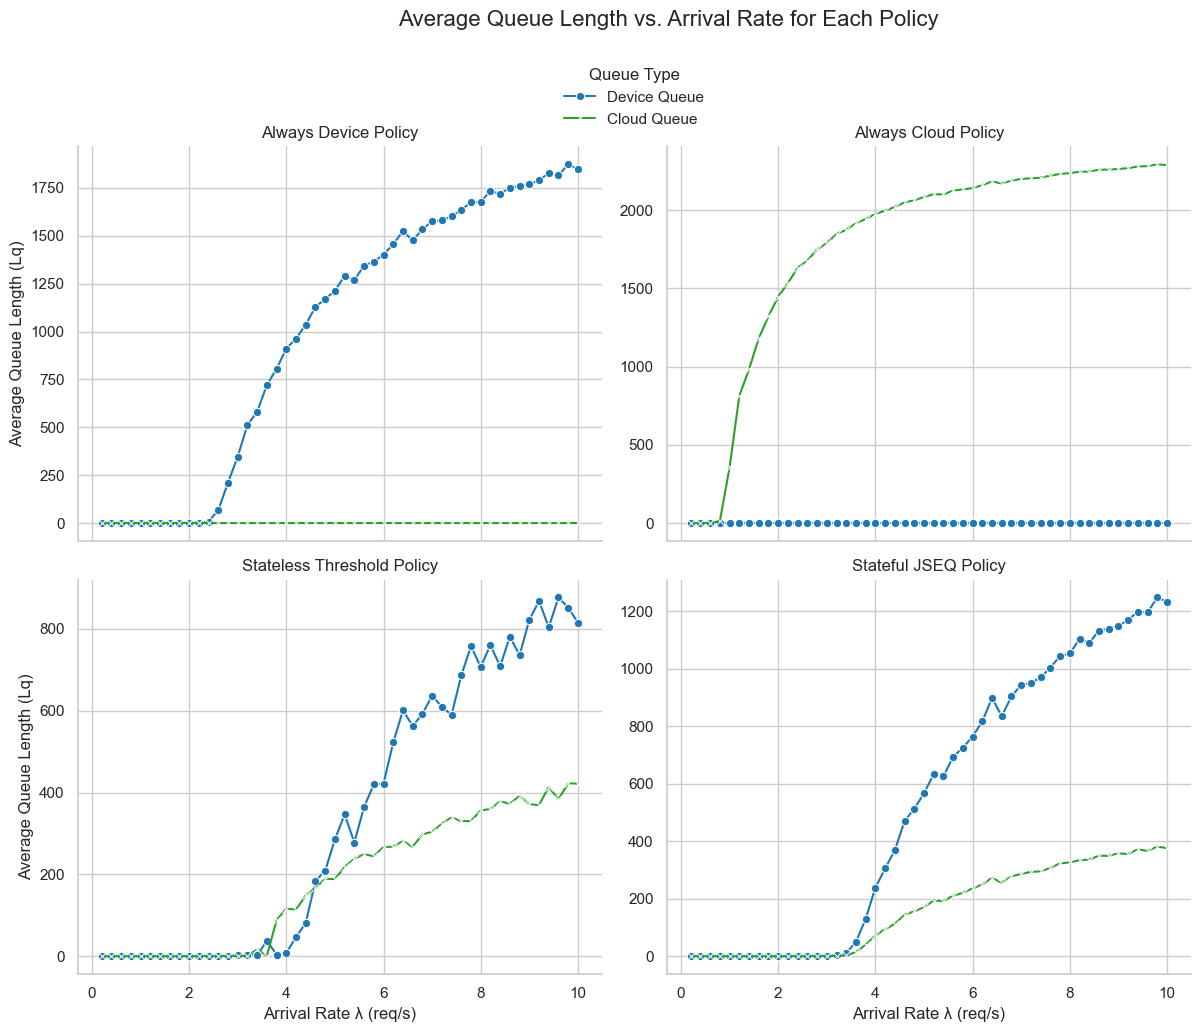

In [138]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import *

# --- FIX RANDOM SEED FOR REPRODUCIBILITY ---
random.seed(0)
np.random.seed(0)

# --- 1. SETUP ---
#test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9] 
num_sim_requests = 5000
policies_to_test = ['Always Device', 'Always Cloud', 'Stateless Threshold', 'Stateful JSEQ']
detailed_results = []

# --- 2. MODIFIED SIMULATION RUNNER TO COLLECT DETAILED STATS ---
# FIX: The runner now needs to know the policy name to handle the stateless case correctly.
def run_detailed_policy_simulation(policy_name, scheduler, requests, stateless_threshold=None):
    """Runs a simulation and returns detailed statistics for each request."""
    request_stats = []
    scheduler.reset()

    # For the 'Stateless Threshold' policy, we must simulate it statelessly.
    # This means using a new, clean scheduler for each decision to prevent state carry-over.
    if policy_name == 'Stateless Threshold':
        # This temporary scheduler will be used to process all requests for this run.
        # Its internal state will be updated correctly for each request.
        temp_stateless_scheduler = StatefulScheduler(dev_model=scheduler.dev_model, cloud_model=scheduler.cloud_model)
        for req in requests:
            if req['size'] <= stateless_threshold:
                decision, start_time, finish_time = temp_stateless_scheduler.route_to_device(req['size'], req['arrival_time'])
            else:
                decision, start_time, finish_time = temp_stateless_scheduler.route_to_cloud(req['size'], req['arrival_time'])
            
            wait_time = start_time - req['arrival_time']
            service_time = finish_time - start_time
            request_stats.append({'wait_time': wait_time, 'service_time': service_time, 'decision': decision})
    else:
        # For all other stateful policies, the original logic is correct.
        for req in requests:
            decision, start_time, finish_time = scheduler.decide_at_time(req['size'], req['arrival_time'])
            wait_time = start_time - req['arrival_time']
            service_time = finish_time - start_time
            request_stats.append({'wait_time': wait_time, 'service_time': service_time, 'decision': decision})
            
    return request_stats

# --- 3. MAIN SIMULATION LOOP ---
print("--- Running simulations for different arrival rates ---")

for lam in test_lambdas:
    print(f"\n>>> Simulating for λ = {lam:.2f} req/s...")
    
    # --- a) Generate a consistent request stream for this lambda ---
    request_stream = []
    current_time = 0.0
    for i in range(num_sim_requests):
        inter_arrival_time = random.expovariate(lam)
        current_time += inter_arrival_time
        input_len = int(max(1, np.random.normal(char_mean, char_std)))
        request_stream.append({'id': i, 'arrival_time': current_time, 'size': input_len})

    # --- b) Find the optimal threshold for the Stateless policy AT THIS LAMBDA ---
    thresholds_scan = range(0, 2500, 100)
    best_latency_for_T = float('inf')
    optimal_T_stateless = -1
    
    # This sub-simulation is to find the best T. It needs its own request stream.
    temp_request_stream = []
    temp_current_time = 0.0
    for i in range(2000): 
        inter_arrival_time = random.expovariate(lam)
        temp_current_time += inter_arrival_time
        input_len = int(max(1, np.random.normal(char_mean, char_std)))
        temp_request_stream.append({'arrival_time': temp_current_time, 'size': input_len})

    for T in thresholds_scan:
        # Create a completely new scheduler for each threshold test to ensure a clean state.
        temp_scheduler = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))
        total_latency = 0.0
        for req in temp_request_stream:
            if req['size'] <= T:
                _, _, finish_time = temp_scheduler.route_to_device(req['size'], req['arrival_time'])
            else:
                _, _, finish_time = temp_scheduler.route_to_cloud(req['size'], req['arrival_time'])
            total_latency += (finish_time - req['arrival_time'])
        avg_latency = total_latency / len(temp_request_stream)
        if avg_latency < best_latency_for_T:
            best_latency_for_T = avg_latency
            optimal_T_stateless = T
    print(f"  Optimal stateless T for λ={lam:.2f} is {optimal_T_stateless} chars.")

    # --- c) Initialize all schedulers ---
    schedulers = {
        'Stateful JSEQ': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud)),
        'Always Cloud': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='cloud'),
        'Always Device': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='device'),
        'Stateless Threshold': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))
    }
    # We no longer override decide_at_time. We pass the threshold to the runner.

    # --- d) Run simulation and process results for each policy ---
    for policy_name in policies_to_test:
        stats = run_detailed_policy_simulation(
            policy_name, 
            schedulers[policy_name], 
            request_stream, 
            stateless_threshold=optimal_T_stateless
        )
        df_stats = pd.DataFrame(stats)
        
        avg_wait_time = df_stats['wait_time'].mean()
        avg_service_time = df_stats['service_time'].mean()

        # This calculation of total_simulation_time is correct.
        df_stats['finish_time'] = df_stats['wait_time'] + df_stats['service_time'] + pd.Series([r['arrival_time'] for r in request_stream])
        total_simulation_time = df_stats['finish_time'].max()
        
        df_stats['decision_clean'] = df_stats['decision'].str.strip().str.lower()
        device_stats = df_stats[df_stats['decision_clean'] == 'device']
        cloud_stats = df_stats[df_stats['decision_clean'] == 'cloud']
        
        
        # This is the correct way to calculate effective arrival rate to each queue.
        lambda_device = len(device_stats) / total_simulation_time if total_simulation_time > 0 else 0
        lambda_cloud = len(cloud_stats) / total_simulation_time if total_simulation_time > 0 else 0
        
        # This is the correct way to calculate average wait time in each queue.
        avg_wait_device = device_stats['wait_time'].mean() if not device_stats.empty else 0
        avg_wait_cloud = cloud_stats['wait_time'].mean() if not cloud_stats.empty else 0

                # --- DEBUGGING BLOCK ---
        # Let's inspect the values for one specific case to see what's happening.
        if lam == 0.5 and policy_name == 'Stateless Threshold':
            print("\n--- DEBUGGING OUTPUT ---")
            print(f"Policy: {policy_name}, Lambda: {lam}")
            print("First 5 stats entries:")
            print(df_stats.head())
            print("\nBreakdown:")
            print(f"  Total Sim Time: {total_simulation_time:.2f}s")
            print(f"  Num Device Jobs: {len(device_stats)}, Num Cloud Jobs: {len(cloud_stats)}")
            print(f"  Lambda Device (eff): {lambda_device:.4f}, Lambda Cloud (eff): {lambda_cloud:.4f}")
            print(f"  Avg Wait Device: {avg_wait_device:.6f}, Avg Wait Cloud: {avg_wait_cloud:.6f}")
            print(f"  Calculated Device Q-Len: {lambda_device * avg_wait_device:.4f}")
            print(f"  Calculated Cloud Q-Len: {lambda_cloud * avg_wait_cloud:.4f}")
            print("--- END DEBUGGING ---\n")
        
        # This is the correct application of Little's Law: Lq = λq * Wq
        # If avg_wait_device is non-zero, this will produce a non-zero queue length.
        avg_q_len_device = lambda_device * avg_wait_device
        avg_q_len_cloud = lambda_cloud * avg_wait_cloud
        
        detailed_results.append({
            'Lambda': lam,
            'Policy': policy_name,
            'Avg Wait Time (s)': avg_wait_time,
            'Avg Inference Time (s)': avg_service_time,
            'Avg Device Queue Length': avg_q_len_device,
            'Avg Cloud Queue Length': avg_q_len_cloud
        })
        print(f"  - {policy_name:<20}: Done.")

# --- 4. DISPLAY RESULTS IN A TABLE ---
results_df = pd.DataFrame(detailed_results)

for policy in policies_to_test:
    print(f"\n\n--- Results for: {policy} ---")
    policy_df = results_df[results_df['Policy'] == policy].set_index('Lambda')
    display(policy_df[[
        'Avg Wait Time (s)', 
        'Avg Inference Time (s)', 
        'Avg Device Queue Length', 
        'Avg Cloud Queue Length'
    ]].style.format({
        'Avg Wait Time (s)': '{:.4f}',
        'Avg Inference Time (s)': '{:.4f}',
        'Avg Device Queue Length': '{:.2f}',
        'Avg Cloud Queue Length': '{:.2f}'
    }).background_gradient(
        cmap='viridis', 
        subset=['Avg Wait Time (s)', 'Avg Device Queue Length', 'Avg Cloud Queue Length']
    ))


# --- 5. PLOT QUEUE LENGTHS VS. ARRIVAL RATE ---
import seaborn as sns
sns.set_theme(style="whitegrid")

# Create a FacetGrid to make one subplot per policy
g = sns.FacetGrid(results_df, col="Policy", col_wrap=2, height=5, aspect=1.2, sharey=False)

# Map the line plots for device and cloud queue lengths
g.map_dataframe(sns.lineplot, x="Lambda", y="Avg Device Queue Length", color='#1f77b4', marker='o', label="Device Queue")
g.map_dataframe(sns.lineplot, x="Lambda", y="Avg Cloud Queue Length", color='#2ca02c', marker='x', label="Cloud Queue")

# Adjust titles and labels
g.set_axis_labels("Arrival Rate λ (req/s)", "Average Queue Length (Lq)")
g.set_titles(col_template="{col_name} Policy")

# Add and reposition the legend
g.add_legend(title="Queue Type")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.475, 0.9))

# Add a main title for the entire figure
g.fig.suptitle('Average Queue Length vs. Arrival Rate for Each Policy', y=1.03, fontsize=16)

# Adjust layout to prevent title overlap and make space for the legend
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()